In [1]:
%pylab inline

from PyTools import err, binner, nbins
from sklearn.cluster import DBSCAN
from scipy.optimize import leastsq
from string import join
from scipy.ndimage.filters import gaussian_filter
import paper_style, os

Populating the interactive namespace from numpy and matplotlib


In [2]:
def put_FITS_names(table):
    descr = table.dtype.descr
    for i in xrange(3): descr.pop(0)
    descr = [("input_file", "|S25")] + descr

    new_table = zeros(table.shape[0], dtype=descr)
    new_table["input_file"] = ["spSpec-{0:05d}-{1:04d}-{2:03d}.fit".format(r["mjd"], r["plate"], r["fiberID"]) for r in table]
    for f in new_table.dtype.names[1:]:
        new_table[f] = table[f]
    
    return new_table

par_lbs = [r"$M_\star$", r"$\left<\log{t_\star}\right>_M$", r"$\left<\log{t_\star}\right>_L$",
           r"$\left<\log{Z_\star/Z\odot}\right>_M$", r"$\left<\log{Z_\star/Z\odot}\right>_L$", r"$A_V$"]

if "paper_style" in dir():
    mnorm = 1e9
    od = os.path.expandvars("$HOME/Documents/Papers/photofit_near_paper/")
    par_lbs = [r"$\log{M_\star/M\odot}$", r"$\left<\log{t_\star}\right>_M$", r"$\left<\log{t_\star}\right>_L$",
               r"$\left<\log{Z_\star/Z\odot}\right>_M$", r"$\left<\log{Z_\star/Z\odot}\right>_L$", r"$A_V$",
               r"$A_V$", r"$z$"]
    res_lbs = [r"$\Delta\log{M_\star}$", r"$\Delta\left<\log{t_\star}\right>_M$",
               r"$\Delta\left<\log{t_\star}\right>_L$", r"$\Delta\left<\log{Z_\star}\right>_M$",
               r"$\Delta\left<\log{Z_\star}\right>_L$", r"$\Delta A_V$"]
else:
    mnorm = 1e8
    od = ""
    par_lbs = ["Mass (log/M$\odot$)", "Age (log/yr)", "Age (log/yr)", "Metallicity (log/Z$\odot$)",
               "Metallicity (log/Z$\odot$)", "Dust Extinction (mag)", "Redshift"]

In [3]:
#READ TABLES

catalog = genfromtxt("catalog.txt", dtype=None, names=True)
spec_ne = genfromtxt("spec_ne.txt", dtype=None, names=True)
jpas_ye = genfromtxt("jpas_ye.txt", dtype=None, names=True)
jpas_ne = genfromtxt("jpas_ne.txt", dtype=None, names=True)
jpas_me = genfromtxt("jpas_me.txt", dtype=None, names=True)
gal2005 = genfromtxt("gal2005.txt", dtype=None, names=True)
galtab2 = array([[ 8.91, -0.60, -1.11, -0.00, 9.06, 8.80,  9.46],
                 [ 9.11, -0.61, -1.07, -0.00, 9.09, 8.81,  9.48],
                 [ 9.31, -0.65, -1.10, -0.05, 9.11, 8.85,  9.44],
                 [ 9.51, -0.61, -1.03, -0.01, 9.17, 8.89,  9.49],
                 [ 9.72, -0.52, -0.97,  0.05, 9.23, 8.94,  9.57],
                 [ 9.91, -0.41, -0.90,  0.09, 9.32, 9.00,  9.71],
                 [10.11, -0.23, -0.80,  0.14, 9.46, 9.09,  9.85],
                 [10.31, -0.11, -0.65,  0.17, 9.61, 9.23,  9.93],
                 [10.51, -0.01, -0.41,  0.20, 9.73, 9.34,  9.98],
                 [10.72,  0.04, -0.24,  0.22, 9.82, 9.48, 10.03],
                 [10.91,  0.07, -0.14,  0.24, 9.87, 9.60, 10.06],
                 [11.11,  0.10, -0.09,  0.25, 9.90, 9.67, 10.08],
                 [11.31,  0.12, -0.06,  0.26, 9.92, 9.72, 10.09],
                 [11.51,  0.13, -0.04,  0.28, 9.94, 9.75, 10.11],
                 [11.72,  0.14, -0.03,  0.29, 9.95, 9.76, 10.12],
                 [11.91,  0.15, -0.03,  0.30, 9.96, 9.77, 10.12]])
Lfrac = put_FITS_names(genfromtxt("lumfrac.txt", dtype=None, names=True))
SN = genfromtxt("snr.txt")
Cind = put_FITS_names(genfromtxt("conIndex_test.txt", dtype=None, names=True))

parr = array([-1.69252953, -0.4964394,   9.35303768])
pard = array([ 0.04363491, -0.23994185,  9.56363449])
par0 = array([ 0.32472905, -0.39032184,  9.70852055])
x = linspace(8.0, 10.2)
y = linspace(-0.7, 0.4)

In [4]:
#COMMON MASKS
nmask = array([n in jpas_ne["input_file"] for n in jpas_me["input_file"]], dtype=bool)
# remove galaxies in the metallicity floor of the model grid and galaxies z>0.05 to lift the aperture bias
zmask = (spec_ne["log_Z_L_mod"]>log10(0.004/0.02))&(catalog["redshift"]>=0.05)&((Cind["petroR90_r"]>0.0))

sfgal = (catalog["u_mag"] - catalog["r_mag"])[zmask]<2.22
pagal = (catalog["u_mag"] - catalog["r_mag"])[zmask]>2.22

In [5]:
# COMMON QUANTITIES
s = spec_ne[zmask]
j = jpas_me[zmask]
cat = catalog[zmask]
rat = 3./Cind["petroR90_r"][zmask]
col = (catalog["u_mag"] - catalog["r_mag"])[zmask]
con = (Cind["petroR90_r"][zmask]/Cind["petroR50_r"][zmask])

S = zeros((s.size, 2))
S[:, 0], S[:, 1] = s["log_t_L_mod"], s["log_Z_L_mod"]
J = zeros((j.size, 2))
J[:, 0], J[:, 1] = j["log_t_L_mod"], j["log_Z_L_mod"]

print "tables match? ", all((s["input_file"]==cat["input_file"])&(s["input_file"]==Cind["input_file"][zmask])&(s["input_file"]==j["input_file"]))
print "table sizes: ", con.size

tables match?  True
table sizes:  19530


In [6]:
db = DBSCAN(eps=0.04, min_samples=50).fit(S)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

print unique(labels)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)
c1m = labels==0
c2m = labels==1
noi = labels==-1

colors = ["#114477", "#117733", "#771122"]

[-1  0  1  2]


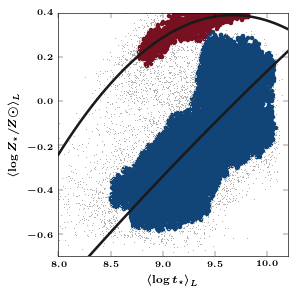

In [7]:
def model(pars, x):
    a, b, c = pars
    return a*asarray(x)**2 + b*asarray(x) + c

def residuals(pars, x, y):
    return y - model(pars, x)

xlim(8.0, 10.2)
ylim(-0.7, 0.4)
xlabel(par_lbs[2])
ylabel(par_lbs[4])

plot(S[c1m, 0], S[c1m, 1], ".", color=colors[0])
plot(S[c2m, 0], S[c2m, 1], ".", color=colors[2])
plot(S[noi, 0], S[noi, 1], ",", color="0.7")

pc1 = leastsq(residuals, [1, 1, 1], (S[c1m, 0], S[c1m, 1]))
pc2 = leastsq(residuals, [1, 1, 1], (S[c2m, 0], S[c2m, 1]))

plot(x, model(pc1[0], x), '-', lw=2, color="0.1")
plot(x, model(pc2[0], x), '-', lw=2, color="0.1")

tight_layout()
#savefig("age_met_clustering")

81.7584131937
93.7665782493


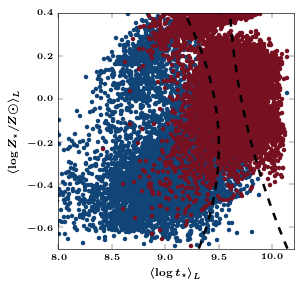

In [8]:
#COMPUTE THE G05 TABLE 2 BINNING (USE AGES FOR BINNING)

xlim(8.0, 10.2)
ylim(-0.7, 0.4)
xlabel(par_lbs[2])
ylabel(par_lbs[4])

plot(S[sfgal, 0], S[sfgal, 1], ".", color=colors[0])
plot(S[pagal, 0], S[pagal, 1], ".", color=colors[2])

parr = array([-1.69252953, -0.4964394,   9.35303768])
pard = array([ 0.04363491, -0.23994185,  9.56363449])
par0 = array([ 0.32472905, -0.39032184,  9.70852055])
plot(model(par0, y), y, '--', lw=2, color="k")
plot(0.5*(model(pard, y)+model(parr, y)), y, '--', lw=2, color="k")

print (S[sfgal, 0]<model(parr, [S[sfgal, 1]])).sum()*100.0/(sfgal).sum()
print (S[pagal, 0]>model(parr, [S[pagal, 1]])).sum()*100.0/(pagal).sum()

#savefig("age_met_scatter")

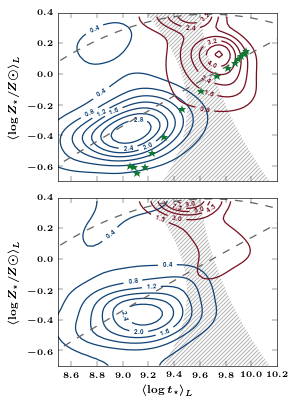

In [22]:
fig, axs = subplots(2, 1, figsize=(3.3, 4.5), sharex=True, sharey=True)

xlim(8.5, 10.2)
ylim(-0.7, 0.4)
axs[1].set_xlabel(par_lbs[2])
axs[0].set_ylabel(par_lbs[4])
axs[1].set_ylabel(par_lbs[4])

nx, xi, xf, bsx = nbins(S[:, 0][sfgal])
ny, yi, yf, bsy = nbins(S[:, 1][sfgal])

H, xe, ye = histogram2d(S[:, 0][sfgal], S[:, 1][sfgal], bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=3)

cont = axs[0].contour(xe[:- 1], ye[:- 1], H.T, colors=colors[0])
clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)

H, xe, ye = histogram2d(J[:, 0][sfgal], J[:, 1][sfgal], bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=3)

cont = axs[1].contour(xe[:- 1], ye[:- 1], H.T, colors=colors[0])
clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)

nx, xi, xf, bsx = nbins(S[:, 0][pagal])
ny, yi, yf, bsy = nbins(S[:, 1][pagal])

H, xe, ye = histogram2d(S[:, 0][pagal], S[:, 1][pagal], bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=3)

cont = axs[0].contour(xe[:- 1], ye[:- 1], H.T, colors=colors[2])
clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)

H, xe, ye = histogram2d(J[:, 0][pagal], J[:, 1][pagal], bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=3)

cont = axs[1].contour(xe[:- 1], ye[:- 1], H.T, colors=colors[2])
clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)

axs[0].fill_betweenx(y, 0.5*(model(pard, y)+model(parr, y)), model(par0, y), linewidth=0, facecolor="none", color="0.7",
              hatch=2*"///")

axs[1].fill_betweenx(y, 0.5*(model(pard, y)+model(parr, y)), model(par0, y), linewidth=0, facecolor="none", color="0.7",
              hatch=2*"///")

pc1 = leastsq(residuals, [1, 1, 1], (S[c1m, 0], S[c1m, 1]))
pc2 = leastsq(residuals, [1, 1, 1], (S[c2m, 0], S[c2m, 1]))
axs[0].plot(x, model(pc1[0], x), "--", lw=1, color="0.4")
axs[0].plot(x, model(pc2[0], x), "--", lw=1, color="0.4")

axs[1].plot(x, model(pc1[0], x), "--", lw=1, color="0.4")
axs[1].plot(x, model(pc2[0], x), "--", lw=1, color="0.4")

axs[0].plot(galtab2[:, 4], galtab2[:, 1], "*", mfc=colors[1], mec="none")

tight_layout()

savefig(od + "AMR")

48.37%
52.93%
55.20%
55.47%
52.00%
59.00%


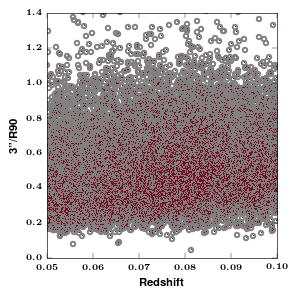

In [11]:
plot(cat["redshift"], rat, ".", mfc="none", mec="0.5", mew=1.5)
plot(cat["redshift"][pagal], rat[pagal], ",", mfc=colors[2])

xlim(0.05, 0.1)
ylim(0.0, 1.4)
xlabel(r"\bf Redshift")
ylabel(r'\bf 3"/R90')

sort_z = argsort(cat["redshift"])
sorted_cat = cat[sort_z]
bin_count = 3000
n_bins = cat.size/bin_count

for i in xrange(n_bins):
    ini = i*bin_count
    fin = (i+1)*bin_count
    
    mask = (sorted_cat["u_mag"]-sorted_cat["r_mag"]) > 2.22
    print "{0:.2f}%".format(sum(mask[ini:fin])*100./bin_count)

tight_layout()
savefig(od + "aper_bias")

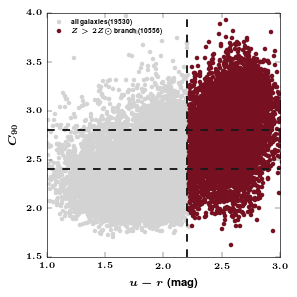

In [12]:
plot(col, con, ".", color="lightgray", label=r"\bf all galaxies (%d)"%con.size)
#plot(col[c1m], con[c1m], ".", color=colors[0], label="~Z$\odot$ branch")
plot(col[pagal], con[pagal], ".", color=colors[2], label=r"\bf $Z>2Z\odot$ branch (%d)"%(sum(pagal)))
legend(loc=2)

axvline(2.2, ls="--", color="0.1", lw=1.5)
axhline(2.4, ls="--", color="0.1", lw=1.5)
axhline(2.8, ls="--", color="0.1", lw=1.5)

xlim(1, 3)
ylim(1.5, 4)
xlabel(r"\bf $u-r$ (mag)")
ylabel(r"\bf $C_{90}$")

tight_layout()